In [1]:
%load_ext Cython

In [2]:
%%time
%%cython
## import usual stuff + cython packages
import numpy as np
import matplotlib.pyplot as plt
import math
from timeit import default_timer as timer
import pickle

cimport cython
cimport numpy as np
from numpy cimport ndarray

## relaxation method to solve laplace's equation
cpdef np.float64_t[:,:] cy_solver(int grid, int maxiter):
    cdef int phi_bottom = 1
    cdef const double[:] x = np.linspace(0, 1, grid)
    cdef const double[:] y = x
    cdef double dx = x[1] - x[0]
    cdef double dy = dx
    cdef double A = 2.0/(dx*dx) + 2.0/(dy*dy)
    cdef double B = 1.0/(dx*dx)
    cdef double C = 1.0/(dy*dy)
    cdef np.float64_t[:,:] phi = np.zeros((grid,grid))
    cdef int t,i,j
    # impose boundary conditions on bottom edge
    phi[:1, :] = phi_bottom
    # relaxation method
    for t in range(maxiter):
        newphi = np.zeros((grid,grid))
        for i in range(1,grid-1):
            for j in range(1,grid-1):
                newphi[i,j] = (B*(phi[i+1,j] + phi[i-1,j]) + C*(phi[i,j+1] + phi[i,j-1]))/A
        for i in range(1,grid-1):
            for j in range(1,grid-1):
                phi[i,j] = newphi[i,j]
    ## plot solution
    colorinterpolation = 100
    colourMap = plt.cm.jet
    plt.contourf(x, y, phi, colorinterpolation, cmap=colourMap)
    plt.colorbar()
    plt.title('Grid = {}, Number of iterations = {}'.format(grid, maxiter))
    plt.savefig('Figures/{}/G{}_I{}.png'.format(grid,grid,maxiter))
    plt.show()
    return phi

## return a 2D array with values of numerical solution at x=0.25 for further comparison
## return a 2D array with time taken to solve laplace equation
cpdef cy_fill_array(int grids, int maxiters, ndarray[:,:] phi_array, np.float64_t[:,:] time_array, list grid_array, np.int64_t[:,:] maxiter_array):
    cdef int i,j
    for i in range(grids):
        for j in range(maxiters):
            start = timer()
            cy_phi = cy_solver(grid_array[i], maxiter_array[i,j])
            end = timer()
            time_taken = end-start
            print('Time taken to solve grid = {}, iterations = {}: {:.3f}s'.format(grid_array[i], maxiter_array[i,j], time_taken))
            cy_phi = np.asarray(cy_phi)
            ## save values of phi at x=0.25 into phi_array
            phi_array[i,j] = cy_phi[math.floor(grid_array[i]/4),:]
            time_array[i,j] = time_taken
    return phi_array, time_array

## plot convergence of solution against x for 1 grid value and all iterations on same figure
## e.g.: 2 grid values, 5 iterations will output 2 figures (5 graphs per figure)
cpdef void convergence(int grids, int maxiters, ndarray[:,:] phi_array, list grid_array, np.int64_t[:,:] maxiter_array):
    cdef int i
    for i in range(grids):
        plt.figure(figsize=(10,7))
        x_axis = np.linspace(0,1,grid_array[i])
        for j in range(maxiters):
            plt.plot(x_axis,phi_array[i,j], label = 'Iterations = {}'.format(maxiter_array[i,j]))
        plt.title('Grid = {}'.format(grid_array[i]))
        plt.xlabel('x')
        plt.ylabel('$\phi$')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
        
## return iteration numbers based on grid size and constant values
cpdef np.int64_t[:,:] get_maxiter_array(list grid_array, list constant_array):
    cdef int grids = len(grid_array)
    cdef int constants = len(constant_array)
    cdef int i,j
    maxiter_array = np.zeros([grids, constants], dtype = np.int64)
    for i in range(grids):
        for j in range(constants):
            maxiter_array[i,j] = math.floor(constant_array[j]* (grid_array[i]**2))
    return maxiter_array

## return avg_diff across all grid points
cpdef np.float64_t[:,:] get_avg_diff(int grids, int maxiters, ndarray[:,:] phi_array):
    cdef int i,j
    avg_diff = np.zeros([grids, maxiters-1])
    for i in range(grids):
        for j in range(maxiters-1):
            ## get difference between analytical and numerical solution
            avg_diff[i,j] = np.sum(np.abs(phi_array[i,phi_array.shape[1]-1]-phi_array[i,j]))/maxiters
    return avg_diff

cpdef void plot_error_time(int grids, list constant_array, np.float64_t[:,:] avg_diff, np.float64_t[:,:] time_array, np.int64_t[:,:] maxiter_array, list grid_array):
    cdef int i
    for i in range(grids):
        fig, ax1 = plt.subplots(figsize=(10,6))
        plt.title('Grid = {}'.format(grid_array[i]))
        x_axis = maxiter_array[i,:-1] ## x_axis is common for both ax1 and ax2
        y_axis = avg_diff[i]
        ax1.scatter(x_axis,y_axis, color='red')
        p = np.polyfit(x_axis, np.log10(y_axis), 1)
        ax1.semilogy(x_axis, np.power(10,p[0]*x_axis + p[1]), color='red')
        ax1.axhline(y=10e-8,c='red')
        ax1.axvline(x=math.ceil(np.log10(grid_array[i]**2))* (grid_array[i]**2),c='black')
        print('Expected Error at A=1: {:.3e}'.format(1.0/(grid_array[i]**2)))
        print('Actual Error at A=1: {:.3e}'.format(avg_diff[i,2]))
        print('Actual Error at A=2: {:.3e}'.format(avg_diff[i,4]))
        print('Actual Error at A=3: {:.3e}'.format(avg_diff[i,6]))
        print('Error p[0]: {:.3e}'.format(p[0]))
        print('Error p[1]: {:.2f}'.format(p[1]))
        ax1.set_xlabel('Constant A')
        ax1.set_ylabel('Error', color='red')
        ax1.tick_params(axis='y', labelcolor='red')

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('Time taken (s)', color='blue')  # we already handled the x-label with ax1
        ax2.scatter(x_axis, time_array[i,:-1], color='blue')
        p = np.polyfit(x_axis, time_array[i,:-1], 1)
        ax2.plot(x_axis, p[0]*x_axis + p[1], color='blue')
        print('Time p[0]: {:.3e}'.format(p[0]))
        print('Time p[1]: {:.2f}'.format(p[1]))
        ax2.tick_params(axis='y', labelcolor='blue')

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        x_ticks = constant_array
        plt.xticks(x_axis, x_ticks)
        plt.show()

CPU times: user 1.38 s, sys: 160 ms, total: 1.54 s
Wall time: 7.75 s
CPU times: user 1.38 s, sys: 160 ms, total: 1.54 s
Wall time: 7.75 s


In [3]:
%%time
## we can change the values of the following 2 lists
grid_array = [25,41,61,81,101,181]
constant_array = [0.1,0.5,1,1.5,2,2.5,3,4,5,8]
# grid_arrray = [25]
## do not edit anything below this line
## solution converges at constant*grid^2 iterations.
## we will vary the constant values to test solution accuracy.
maxiter_array = get_maxiter_array(grid_array, constant_array)
grids = len(grid_array)
maxiters = maxiter_array.shape[1]
## create empty phi_array and empty time_array
phi_array = np.zeros([grids, maxiters] ,dtype=np.ndarray)
time_array = np.zeros([grids, maxiters])

CPU times: user 94 µs, sys: 21 µs, total: 115 µs
Wall time: 118 µs
CPU times: user 94 µs, sys: 21 µs, total: 115 µs
Wall time: 118 µs


In [4]:
%%time
print('Opening pickle files.')
pickle_in = open("phi_array_81.pickle","rb")
phi_81 = pickle.load(pickle_in)
pickle_in = open("phi_array_101.pickle","rb")
phi_101 = pickle.load(pickle_in)
pickle_in = open("phi_array_181.pickle","rb")
phi_181 = pickle.load(pickle_in)
pickle_in = open("time_array_81.pickle","rb")
time_81 = pickle.load(pickle_in)
pickle_in = open("time_array_101.pickle","rb")
time_101 = pickle.load(pickle_in)
pickle_in = open("time_array_181.pickle","rb")
time_181 = pickle.load(pickle_in)

phi_array = np.concatenate((phi_81, phi_101, phi_181), axis=0)
time_array = np.concatenate((time_81, time_101, time_181), axis=0)

Opening pickle files.
CPU times: user 2.42 ms, sys: 3.18 ms, total: 5.6 ms
Wall time: 14.4 ms
Opening pickle files.
CPU times: user 2.42 ms, sys: 3.18 ms, total: 5.6 ms
Wall time: 14.4 ms


Expected Error at A=1: 1.600e-03
Actual Error at A=1: 4.062e-03
Actual Error at A=2: 2.262e-05
Actual Error at A=3: 1.261e-07
Error p[0]: -3.640e-03
Error p[1]: -0.07
Time p[0]: 1.301e-03
Time p[1]: 0.53
Expected Error at A=1: 1.600e-03
Actual Error at A=1: 4.062e-03
Actual Error at A=2: 2.262e-05
Actual Error at A=3: 1.261e-07
Error p[0]: -3.640e-03
Error p[1]: -0.07
Time p[0]: 1.301e-03
Time p[1]: 0.53


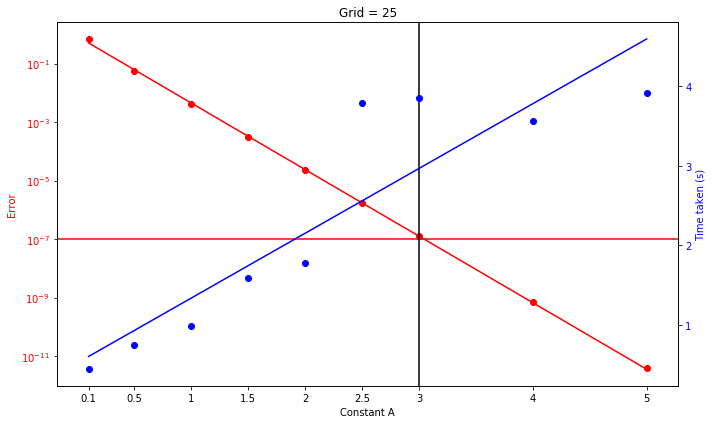

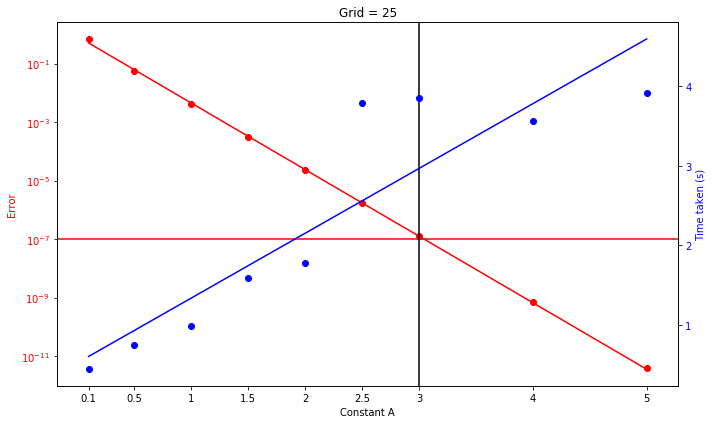

Expected Error at A=1: 5.949e-04
Actual Error at A=1: 9.261e-03
Actual Error at A=2: 5.872e-05
Actual Error at A=3: 3.725e-07
Error p[0]: -1.320e-03
Error p[1]: 0.24
Time p[0]: 5.075e-03
Time p[1]: 0.54
Expected Error at A=1: 5.949e-04
Actual Error at A=1: 9.261e-03
Actual Error at A=2: 5.872e-05
Actual Error at A=3: 3.725e-07
Error p[0]: -1.320e-03
Error p[1]: 0.24
Time p[0]: 5.075e-03
Time p[1]: 0.54


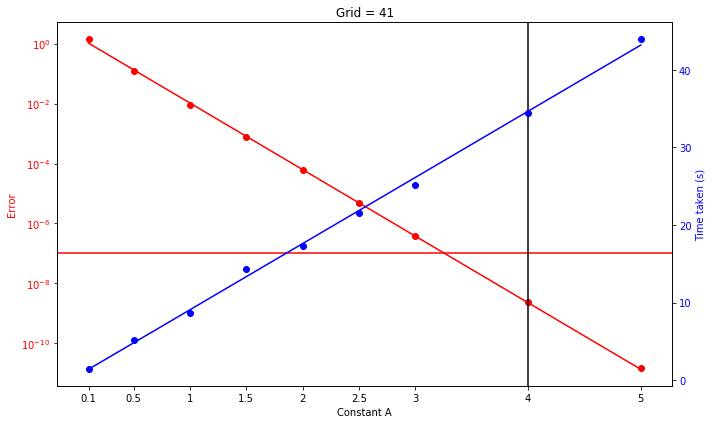

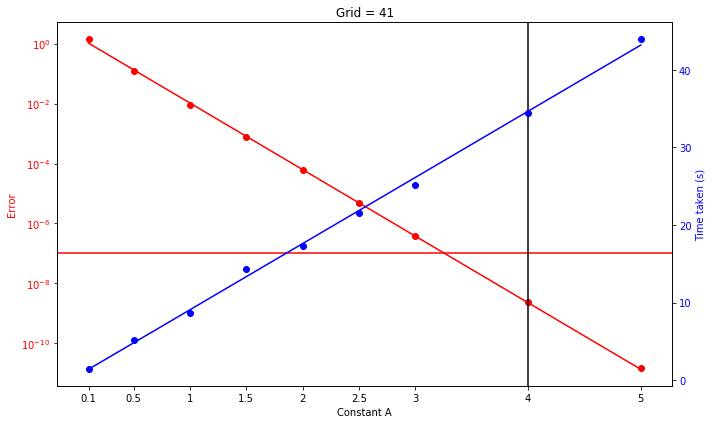

Expected Error at A=1: 2.687e-04
Actual Error at A=1: 2.030e-03
Actual Error at A=2: 9.445e-06
Actual Error at A=3: 4.396e-08
Error p[0]: -6.323e-04
Error p[1]: -0.29
Time p[0]: 2.478e-05
Time p[1]: 0.40
Expected Error at A=1: 2.687e-04
Actual Error at A=1: 2.030e-03
Actual Error at A=2: 9.445e-06
Actual Error at A=3: 4.396e-08
Error p[0]: -6.323e-04
Error p[1]: -0.29
Time p[0]: 2.478e-05
Time p[1]: 0.40


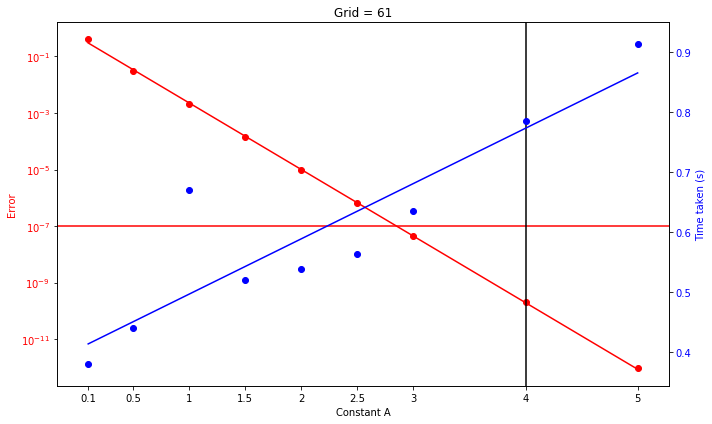

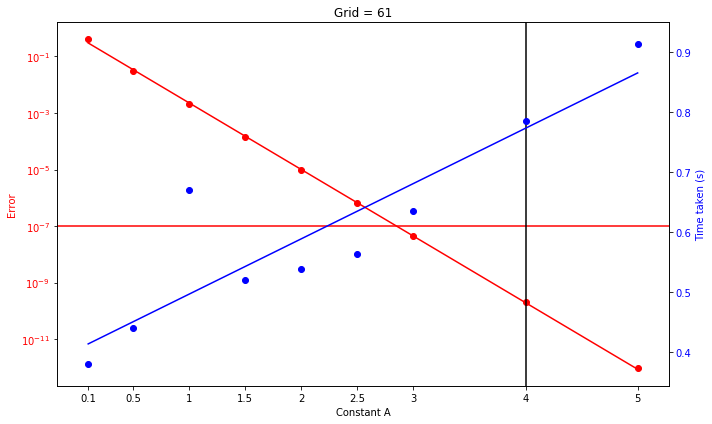

Expected Error at A=1: 1.524e-04
Actual Error at A=1: 6.653e-03
Actual Error at A=2: 4.042e-05
Actual Error at A=3: 2.457e-07
Error p[0]: -3.411e-04
Error p[1]: 0.11
Time p[0]: 4.487e-04
Time p[1]: 1.03
Expected Error at A=1: 1.524e-04
Actual Error at A=1: 6.653e-03
Actual Error at A=2: 4.042e-05
Actual Error at A=3: 2.457e-07
Error p[0]: -3.411e-04
Error p[1]: 0.11
Time p[0]: 4.487e-04
Time p[1]: 1.03


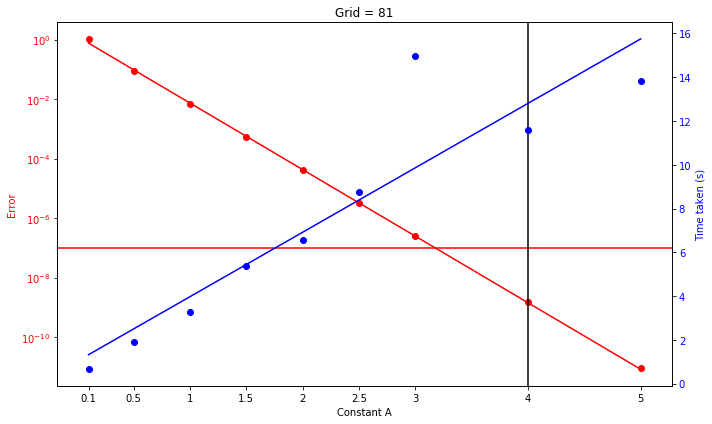

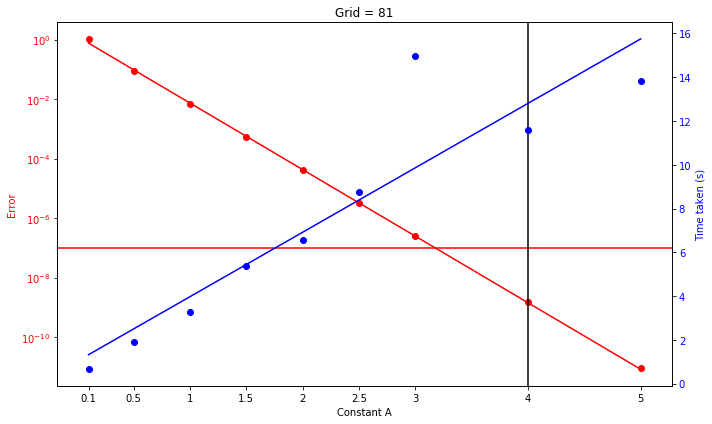

Expected Error at A=1: 9.803e-05
Actual Error at A=1: 1.188e-02
Actual Error at A=2: 7.724e-05
Actual Error at A=3: 5.026e-07
Error p[0]: -2.165e-04
Error p[1]: 0.33
Time p[0]: 2.172e-03
Time p[1]: -0.76
Expected Error at A=1: 9.803e-05
Actual Error at A=1: 1.188e-02
Actual Error at A=2: 7.724e-05
Actual Error at A=3: 5.026e-07
Error p[0]: -2.165e-04
Error p[1]: 0.33
Time p[0]: 2.172e-03
Time p[1]: -0.76


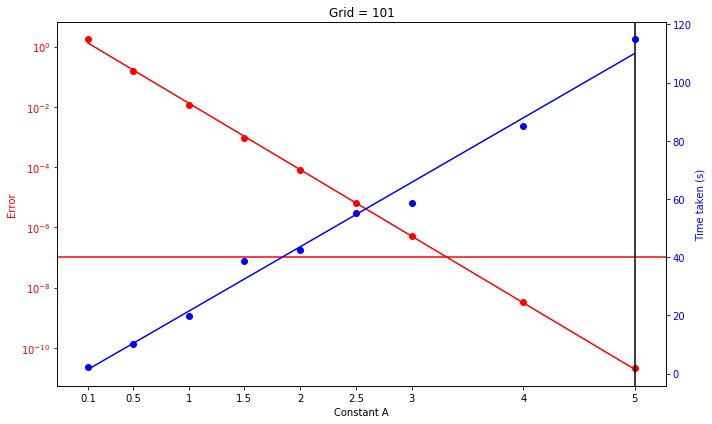

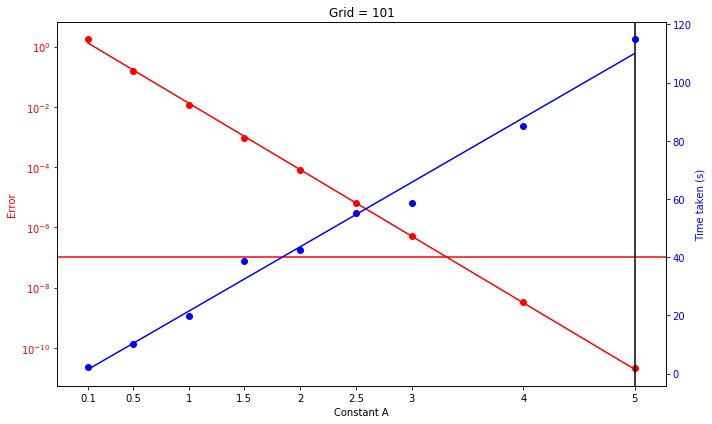

Expected Error at A=1: 3.052e-05
Actual Error at A=1: 2.236e-02
Actual Error at A=2: 1.521e-04
Actual Error at A=3: 1.035e-06
Error p[0]: -6.686e-05
Error p[1]: 0.59
Time p[0]: 6.283e-03
Time p[1]: 18.12
Expected Error at A=1: 3.052e-05
Actual Error at A=1: 2.236e-02
Actual Error at A=2: 1.521e-04
Actual Error at A=3: 1.035e-06
Error p[0]: -6.686e-05
Error p[1]: 0.59
Time p[0]: 6.283e-03
Time p[1]: 18.12


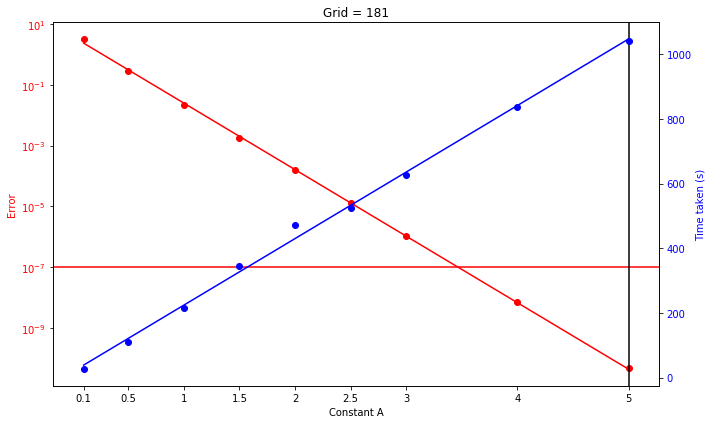

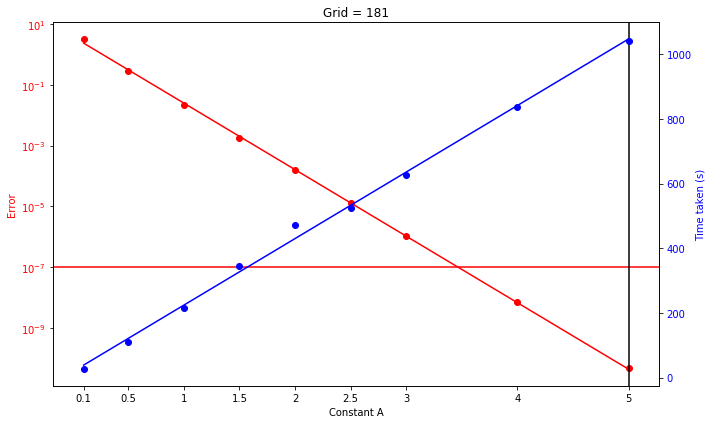

CPU times: user 4.45 s, sys: 455 ms, total: 4.91 s
Wall time: 2.83 s
CPU times: user 4.45 s, sys: 455 ms, total: 4.91 s
Wall time: 2.83 s


In [5]:
%%time
## create avg_diff array
avg_diff = np.asarray(get_avg_diff(grids, maxiters, phi_array))
## plot error and time against constant value
plot_error_time(grids, constant_array, avg_diff, time_array, maxiter_array, grid_array)

In [ ]:
# %%time
## solve and plot phi
## phi_array is the array with saved values of phi at x=0.25
phi_array, time_array = cy_fill_array(grids, maxiters, phi_array, time_array, grid_array, maxiter_array)
phi_array = np.asarray(phi_array)
## time_array is the array with saved values of how long it takes to run the function
time_array = np.asarray(time_array)

In [ ]:
%%time
## plot convergence of numerical solution with different iteration values
convergence(grids, maxiters, phi_array, grid_array, maxiter_array)